# Determining corrections to the number of positives

The number of daily positives $P_i$, has to be scaled in relation to the number of daily tests $T_i$ as $(T_i/\bar{T})^{-\gamma}$, as the number of positives does not grow linearly with number of tests.
Furthermore, variation with weekday remains, which should be subsequently corrected for.

The following code determins from the (PCR) test data:
- Measuring the scaling exponent of positives with respect to number of tests
- Determining further weekday corrections

Thus, the below code measures this exponent, as the current value of $\gamma = 0.7$ was determined several months ago (by Uffe from SSI), and may have changed. Also a measurement of this value for the AntiGen test is in order. The estimates should be done for both the entire period (e.g. 1st of September 2020 - 1st of March 2021) and possibly also monthly to test, if there are significant variations.

The analysis is related to the observation, that the fraction of positives usually increases on Mondays (i.e. results from the weekend). However, one should **first** determine $\gamma$, and if any weekly variations remain, these should be accounted for **subsequently**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scipy 
import datetime as dt
# from scipy.optimize import curve_fit, minimize
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit
from scipy.optimize import curve_fit
import os

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

### General settings:

In [2]:
save_plots = True

day_0 = '2020-12-14'
fit_to_today = False
gamma_period = ['2020-12-14', '2021-03-08']

date_start = '2020-12-14'
date_end   = '2021-03-08'

***

# Fit to current test & positive numbers:

## Read the data:

Here the input should be a text file with the rows from the .pdf copied in with the last day first. See the provided .txt file for an example.

In [3]:
#data = pd.read_csv("../PrivateData/PrivateData090321.csv", sep=',', index_col=0)
filepath = "../PrivateData/PrivateData090321.txt" #In a seperate folder for now, subject to change

with open(filepath, 'r') as data: #Pretty messy code, could be changed with better inputs
    lines = data.readlines()
    n = len(lines)
    Np_AG = np.zeros(n)
    Nt_AG = np.zeros(n)
    Np_PCR = np.zeros(n)
    Nt_PCR = np.zeros(n)
    days = np.zeros(n, dtype=object)
    for index, line in enumerate(lines):
        x = line.split()
        days[index] = x[0].replace('.','-') #Changing separators
        days[index] = days[index][6:] + '-' + days[index][3:5] + '-' + days[index][:2] #Converting into right format
        Nt_AG[index] = float(x[5].replace('.',''))#Removing separators if they exist
        Np_AG[index] = float(x[6].replace('.',''))
        Nt_PCR[index] = float(x[2].replace('.',''))
        Np_PCR[index] = float(x[3].replace('.',''))

all_data = pd.DataFrame(np.array([days, Nt_AG, Np_AG, Nt_PCR, Np_PCR]).T, columns=['Day', 'Nt_AG', 'Np_AG', 'Nt_PCR', 'Np_PCR'])
#Have to assert this or some calculations do not work
all_data = all_data.astype({'Day': 'datetime64', 'Nt_AG': 'int64', 'Nt_PCR': 'int64', 'Np_AG': 'int64', 'Np_PCR': 'int64'}) 
all_data = all_data.set_index('Day')


# All of Denmark
if fit_to_today:
    date_end = data_test.index[-1]
    
P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
eP_AG = np.sqrt(P_AG)
N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
eN_AG = np.sqrt(N_AG)
P_PCR = np.flip(all_data["Np_PCR"][date_end:date_start])
eP_PCR = np.sqrt(P_PCR)
N_PCR = np.flip(all_data["Nt_PCR"][date_end:date_start])
eN_PCR = np.sqrt(N_PCR)
day  = np.arange(1,len(P_AG)+1)

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = 0.56         # Power in power law for the increase in positives with increase in tests.
# SystError = 0.000   # To account for larger uncertainties on fraction positives than simply the statistical.

# TP 6. March: Are the above necessary? And the below scaling (yet)?
# TP 8. March: Better naming of....  P -> SP -> SCP

nAveDailyTests_AG = N_AG.mean()
nAveDailyTests_PCR = N_PCR.mean()
print("Average number of AntiGen tests: ", nAveDailyTests_AG)
print("Average number of PCR tests: ", nAveDailyTests_PCR)
fPos_AG = P_AG / N_AG
nPos_AG  = P_AG * (N_AG / nAveDailyTests_AG)**(-Power)
enPos_AG = (N_AG*fPos_AG*(1-fPos_AG) ) ** 0.5 * (N_AG / nAveDailyTests_AG)**(-Power)
fPos_PCR = P_PCR / N_PCR
nPos_PCR  = P_PCR * (N_PCR / nAveDailyTests_PCR)**(-Power)
enPos_PCR = (N_PCR*fPos_PCR*(1-fPos_PCR) ) ** 0.5 * (N_PCR / nAveDailyTests_PCR)**(-Power)

all_data.dtypes

Average number of AntiGen tests:  30903.564705882352
Average number of PCR tests:  1162.2117647058824


Nt_AG     int64
Np_AG     int64
Nt_PCR    int64
Np_PCR    int64
dtype: object

## Define ranges, fitting function, and model:

In [4]:
Plot_StartDay = 1
Plot_EndDay   = 26

Fit_StartDay  = 0
Fit_EndDay    = 33
day1jan       = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit   = np.arange(Fit_StartDay, Fit_EndDay)
Npoints = len(day1jan_fit)

day_extrapol = 20


### Comparison of geometric mean with scaled positives
First we define a likelihood for comparingf geometric mean of scaled positives and scaled positives with variable scaling, $\gamma$. Then best fit and uncertainty on gamma within time-period is defined

In [5]:
def model_bllh_og(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf[N_obs < N_exp]  = scipy.stats.poisson.logcdf( N_obs[N_obs < N_exp], N_exp[N_obs < N_exp] )
    p_cdf[N_obs >= N_exp] = scipy.stats.poisson.logsf(  N_obs[N_obs >= N_exp], N_exp[N_obs >= N_exp] )
    return - 2 * sum( (p_cdf) )

def model_bllh(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf  = scipy.stats.poisson.logcdf( N_obs, N_exp )
    p_cdf[p_cdf >= np.log(0.5)] = scipy.stats.poisson.logsf(  N_obs[p_cdf >= np.log(0.5)], N_exp[p_cdf >= np.log(0.5)] )
    return - 2 * sum( (p_cdf) )

#Find likelihood of N_obs given N_exp with poisson statistics

def gamma_index(P, N, AveDaily): #finds best fit gamma and uncertainty for period
    llh_list = []
    gamma_list = np.linspace(0,1.,101) #probe gamma in discrete values. 
    for gamma in gamma_list:
        nPos_all  = P * (N / AveDaily)**(-gamma)
        enPos_all = np.sqrt(P * (N / AveDaily)**(-gamma))
    
        y = nPos_all[Plot_StartDay:Plot_EndDay]
        y_exp = []
        for i in range(3,len(y)-3):
            y_exp.append( (np.prod(y[i-3:i+4]))**(1/7) ) 
            #Geometric running average, predicted scaled positive test number
            #Problems here with PCR as there are sometimes zero positive tests which results in errors further along
        llh = model_bllh( np.array(nPos_all[Plot_StartDay+4:Plot_EndDay-2].values), np.array(y_exp) )
        llh_list.append(llh)     
    min_llh = min(llh_list)
    
    p = np.polyfit(gamma_list[np.isclose(llh_list, min_llh, atol=10.)], 
               np.array(llh_list)[np.isclose(llh_list, min_llh, atol=10.)], 2)
    print(p)
    gamma = -p[1]/(2*p[0])
    dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma 
    #Fails for some gamma due to the first element being negative
    
    return gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp

#gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp = gamma_index()

### Compare $\gamma (t)$

Compute $\gamma (t)$ as a linear function using locally computed geometric mean

From this point on everything is only on AntiGen tests as the PCR tests give errors

In [6]:
gamma_t_AG = []
dgamma_t_AG = []
gamma_t_PCR = []
dgamma_t_PCR = []


days_between_points = 7
for i in np.arange(0,len(all_data["Np_AG"][date_end:date_start]) - 28,days_between_points): 
    #loop over every days_between_points days from september to february
    P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
    eP_AG = np.sqrt(P_AG)
    N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
    eN_AG = np.sqrt(N_AG)
    P_PCR = np.flip(all_data["Np_PCR"][date_end:date_start])
    eP_PCR = np.sqrt(P_PCR)
    N_PCR = np.flip(all_data["Nt_PCR"][date_end:date_start])
    eN_PCR = np.sqrt(N_PCR)
    day  = np.arange(1,len(P_AG)+1)
    
    Plot_StartDay = i
    Plot_EndDay   = 28+i

    nAveDailyTests_AG = N_AG.mean()
    nAveDailyTests_PCR = N_PCR.mean()
    
    fPos_PCR = P_PCR / N_PCR
    fPos_AG = P_AG / N_AG
    gamma_AG, dgamma_AG, llh_list_AG, gamma_list_AG, nPos_all_AG, enPos_all_AG, y_exp_AG = gamma_index(P_AG, N_AG, nAveDailyTests_AG)
    gamma_t_AG.append(gamma_AG), dgamma_t_AG.append(dgamma_AG)
    #gamma_PCR, dgamma_PCR, llh_list_PCR, gamma_list_PCR, nPos_all_PCR, enPos_all_PCR, y_exp_PCR = gamma_index(P_PCR, N_PCR, nAveDailyTests_PCR)
    #gamma_t_PCR.append(gamma_PCR), dgamma_t_PCR.append(dgamma_PCR) #Does not work due to zero positive tests on some days

[ 2574.21938351 -1656.63658419   570.27144429]
[1894.57532633 -971.97974596  415.93641178]
[1154.45705894 -889.13053503  344.59838896]
[106.38223933 -26.93121342 134.38407993]
[-187.6572957    81.78443512  112.9915681 ]


<ipython-input-5-921414eceb15>:36: RuntimeWarning: invalid value encountered in sqrt
  dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma


[-158.59146084   75.33503788  135.20514413]
[ 68.9675333   -9.27872497 165.59781512]
[110.09808297 -55.34652423 176.45352495]
[ 106.93303679 -107.97885071  155.05732606]


Here we plot $\gamma(t)$ 

[0.01970957 0.02297439 0.02943141 0.09695393 0.02       0.02
 0.12041419 0.09530378 0.09670391]


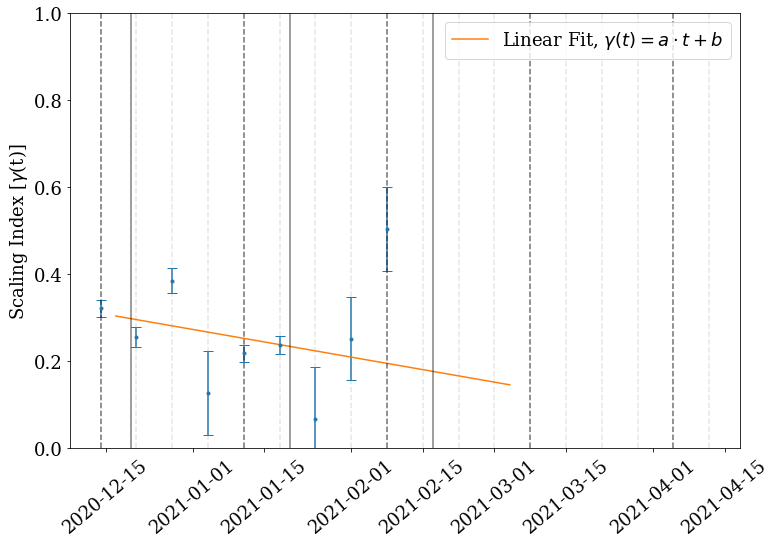

In [25]:
days = days_between_points*np.arange(len(gamma_t_AG)) 
now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:]))

dates = []
for x in np.arange(len(gamma_t_AG)):
    dates.append(now + dt.timedelta(days=int(days_between_points*x)))

plt.figure(figsize=(12,8))
plt.errorbar(dates, gamma_t_AG, yerr=dgamma_t_AG, fmt='.', capsize=5)
plt.ylabel(r'Scaling Index [$\gamma$(t)]')#, plt.xlabel('Days from '+date_start)
plt.ylim(0,1)#, plt.legend() 

#Testing
dgamma_t_AG = np.nan_to_num(dgamma_t_AG,nan=0.02) #Replace NaN by some number

print(dgamma_t_AG)

#fit linear function
def lin(x,a,b):
    return a*x+b
p, cov = curve_fit(lin, days, gamma_t_AG, sigma=dgamma_t_AG)
power = lin(np.arange(3,len(P_AG[date_start:date_end])-4), *p)

#Heavyside
#power = []
#for idx,i in enumerate(Ntest_all[date_start:date_end][3:-4].index):
#    if idx < 90:
#        power.append(0.78)
#    else:
#        power.append(0.57)
plt.plot(N_AG[date_start:date_end][3:-4].index, power, label=f'Linear Fit, $\gamma (t) = a \cdot t + b$')        

#This creates weekly lines


for x in np.arange(0,120,7): #weeks
    plt.axvline( now + dt.timedelta(days=int(x)), ls='--', color='grey', alpha=0.2)
for x in np.arange(0,120,28): #month 
    plt.axvline( now + dt.timedelta(days=int(x)), ls='--', color='k', alpha=0.5)
    
# Plot monthly lines on first date
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
for i in range(len(P_AG)):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        plt.axvline( d_now-dt.timedelta(days=12), ls='-', color='k', alpha=0.5)
    
times = []; N_weeks = int(len(P_AG)/14)
for i in range(N_weeks):
    times.append(d_now + dt.timedelta(days=14*i))
    
#plt.xticks(ticks=[14*i for i in range(N_weeks)], 
#          labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times], rotation=30 );
plt.legend(loc='best')
plt.xticks(rotation = 40)
plt.savefig('gamma_t_2.png', dpi=300)

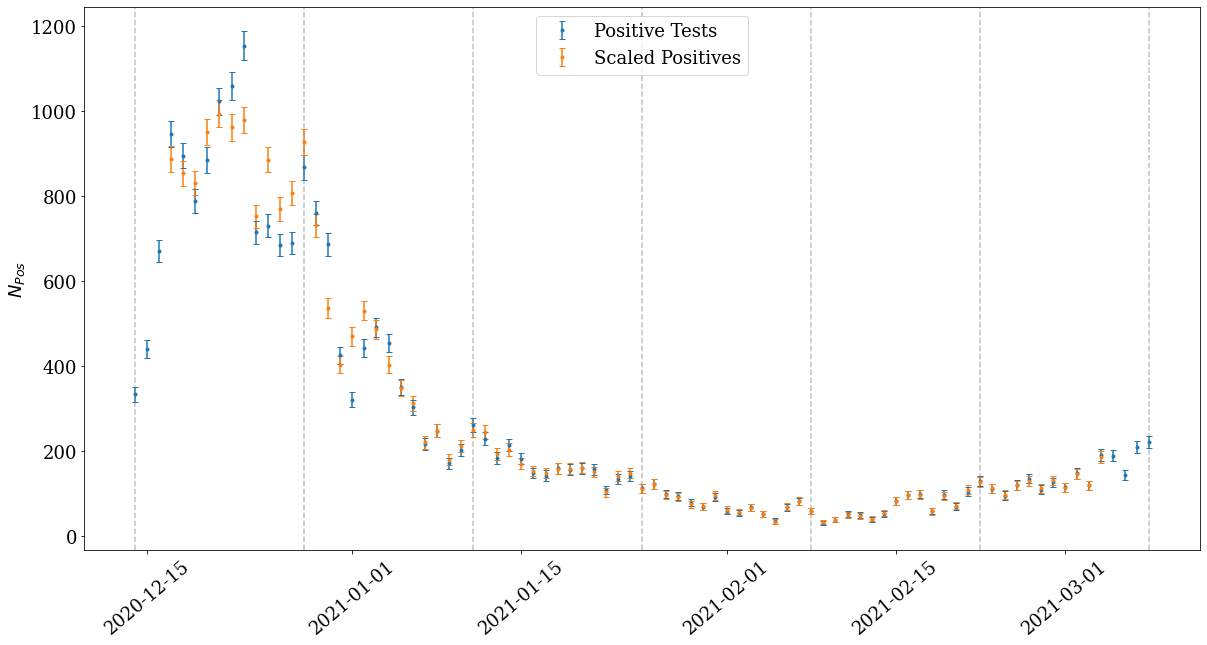

In [11]:
plt.figure(figsize=(20,10))
plt.errorbar(P_AG.index, P_AG[date_start:date_end], 
             yerr = eP_AG[date_start:date_end], fmt='.', capsize=3, label='Positive Tests')


now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:]))

#includes date on x-label
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::14]))
#for label in temp:
#    label.set_visible(False)
for x in np.arange(0,len(P_AG[date_start:date_end]),14): #weeks
    plt.axvline(now + dt.timedelta(days=int(x)), ls='--', color='grey', alpha=0.5)
    
mean_arr = []
for i in np.arange(3,len(P_AG[date_start:date_end])-4): 
    mean_arr.append( np.mean(N_AG[date_start:date_end][i-3:i+4]) )
SP = P_AG[3:-4] * (N_AG[date_start:date_end][3:-4]/mean_arr)**(-np.asarray(power) )


plt.errorbar(SP.index, SP[date_start:date_end], 
             yerr = np.sqrt(SP[date_start:date_end]), fmt='.', capsize=3, label='Scaled Positives')
plt.ylabel(r'$N_{Pos} $')
plt.xticks(rotation = 40); plt.legend();

plt.savefig('Scaled_pos.png', dpi=300)




Given $\gamma (t)$ compute the locally scaled positive test rate and plot residuals.
Week_coor compares scaled positive to total positives to show weekly bias. 

In [ ]:
# THIS IS THE OLD THING - NOT TO BE USED!!!
"""
def week_corr(dato_start = "2020-08-28", dato_end   = "2020-12-01", power=0.56):
    Nposi_all = data_posi.loc[dato_start:dato_end].sum(axis=1)
    eNposi_all = np.sqrt(Nposi_all)
    Ntest_all = data_test.loc[dato_start:dato_end].sum(axis=1)
    eNtest_all = np.sqrt(Ntest_all)
    mean_arr = []
    
    #Calculate mean of tested in week
    for i in np.arange(3,len(Nposi_all)-4): 
        mean_arr.append( np.mean(Ntest_all[i-3:i+4]) )
    
    #Scale Positive tested
    SP = Nposi_all[3:-4] * (Ntest_all[3:-4]/mean_arr)**(-power)
    
    #Fractional correction by weekday
    n_days = (len(np.arange(3,len(Nposi_all)-4)) % 7)
    nweeks = int((len(np.arange(3,len(Nposi_all)-4))-n_days) / 7)
    if n_days == 0: 
        SP_week = np.reshape(SP.values, (nweeks, 7))
        Nposi_week = np.reshape(Nposi_all[3:-4].values, (nweeks, 7))
    else:
        SP_week = np.reshape(SP.values[:-(len(np.arange(3,len(Nposi_all)-4)) % 7)], (nweeks, 7))
        Nposi_week = np.reshape(Nposi_all[3:-4].values[:-(len(np.arange(3,len(Nposi_all)-4)) % 7)], (nweeks, 7))
        
    mean, spread = np.mean((SP_week-Nposi_week)/SP_week, axis=0), np.std((SP_week-Nposi_week)/SP_week, axis=0)/np.sqrt(nweeks-1)
    
    return mean, spread

mean, spread = week_corr(dato_start = "2020-09-01", dato_end   = "2020-12-15", power=0.8)
"""

In [12]:
def fractional_dev(mean, spread, date_start, dato_end):
    roll = dt.date(int(date_start[:4]), int(date_start[5:7]), int(date_start[8:]) ).weekday() + 3   
    
    plt.figure(figsize=(10, 7))
    plt.errorbar(np.arange(len(mean)), np.roll(mean, roll), yerr=np.roll(spread,roll), 
                 fmt='.', capsize=10,  color='b', label=date_start+' to '+dato_end)
    #plt.errorbar(np.arange(len(mean)), mean, yerr=spread, fmt='.', capsize=10,  color='r')
    
    plt.legend()
    plt.ylabel('Fractional Deviation')
    plt.axhline(0, ls='--', color='k')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=25);
    
#plt.savefig('Weekly_Oscilation.png', dpi=300)

In [ ]:
# fractional_dev(mean, spread, "2020-09-01", date_end)

# plt.savefig('Fractional_deviation_wo_gamma.png', dpi=300)

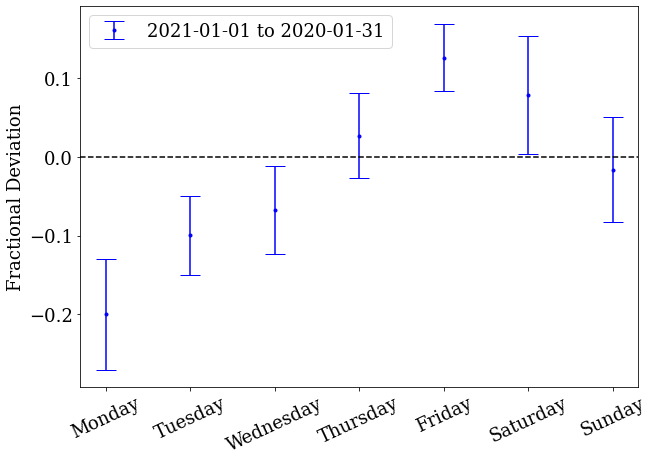

In [16]:
def week_corr_sp_sys_AG(dato_start = "2021-01-01", dato_end   = "2020-01-31", power=0.56):
    P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
    eP_AG = np.sqrt(P_AG)
    N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
    eN_AG = np.sqrt(N_AG)
    mean_arr = []
    
    # Calculate mean of tested in week:
    for i in np.arange(3,len(P_AG)-4): 
        mean_arr.append( np.mean(N_AG[i-3:i+4]) )
    
    # Scale Positive tested in week:
    SP = P_AG[3:-4] * (N_AG[3:-4]/mean_arr)**(-power)
    SP_exp = np.zeros_like(SP)
    
    # Geometric mean of the Scaled Positives:
    for i in np.arange(3,len(SP)-4): 
        SP_exp[i] = (np.prod(SP[i-3:i+4]))**(1/7)
    
    # Fractional correction by weekday:
    n_days = (len(np.arange(3,len(SP_exp)-4)) % 7)
    nweeks = int((len(np.arange(3,len(SP_exp)-4))-n_days) / 7)
    if n_days == 0: 
        SP_week = np.reshape(SP_exp[3:-4], (nweeks, 7))
        Nposi_week = np.reshape(SP[3:-4].values, (nweeks, 7))
    else:
        SP_week = np.reshape(SP_exp[3:-4][:-(len(np.arange(3,len(SP)-4)) % 7)], (nweeks, 7))
        Nposi_week = np.reshape(SP[3:-4].values[:-(len(np.arange(3,len(SP)-4)) % 7)], (nweeks, 7))
        
    mean, spread = np.mean((SP_week-Nposi_week)/SP_week, axis=0), np.std((SP_week-Nposi_week)/SP_week, axis=0)/np.sqrt(nweeks-1)
    
    return mean, spread, SP, SP_exp, P_AG

mean1, spread1, SP, SP_exp, Nposi_all = week_corr_sp_sys_AG(dato_start = date_start, dato_end = date_end)

fractional_dev(mean1, spread1, "2021-01-01", "2020-01-31")
plt.savefig('Fractional_deviation_wo_gamma.png', dpi=300)

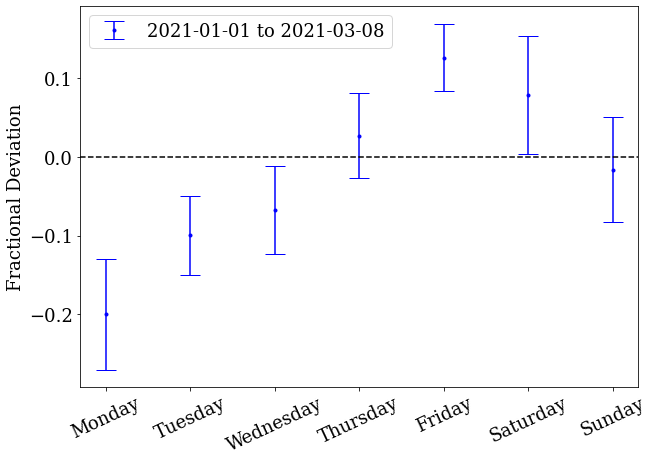

In [18]:
mean, spread, SP, SP_exp,Nposi_all = week_corr_sp_sys_AG(dato_start = '2021-01-01', dato_end   = date_end)

fractional_dev(mean, spread, "2021-01-01", date_end)

In [ ]:
mean, spread, SP, SP_exp,Nposi_all = week_corr_sp_sys(dato_start = '2020-09-01', dato_end   = '2020-12-15')

fractional_dev(mean, spread, "2021-09-01", '2020-12-15')

In [19]:
mean

array([-0.20020232, -0.09986616, -0.06708909,  0.02693524,  0.12626822,
        0.07851387, -0.01622461])

In [20]:
spread

array([0.07034345, 0.05074969, 0.05607189, 0.05388658, 0.04301095,
       0.07468952, 0.06700328])

In [21]:
np.sum( (mean/spread)**2)

23.43597184314478

In [22]:
stats.chi2.sf( 24, 7)  

0.001139351178947464

In [23]:
np.sum( (mean-np.roll(mean1, -3))**2/(spread**2) )

101.56005673550573

In [24]:
(mean-np.roll(mean1, -3))**2/(spread**2)

array([10.42630923, 19.85483624,  6.7429508 ,  0.64150283, 57.6142567 ,
        5.70391638,  0.57628455])